# AWESim SOSS

**Analyzing Webb Exoplanet Simulations with SOSS**

In [2]:
# Magic functions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Imports
import numpy as np
import astropy.units as q
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from AWESim_SOSS.sim2D import awesim

/Users/jfilippazzo/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Late-M Dwarf TSO

Here is how to generate time series observations of a brown dwarf (or any other isolated star with no transiting planet).

We need two components to generate this simulation:
- A flux calibrated stellar spectrum
- A specified number of integrations and groups for the observation

Let's use this 3500K stellar spectrum with a J magnitude of 9.

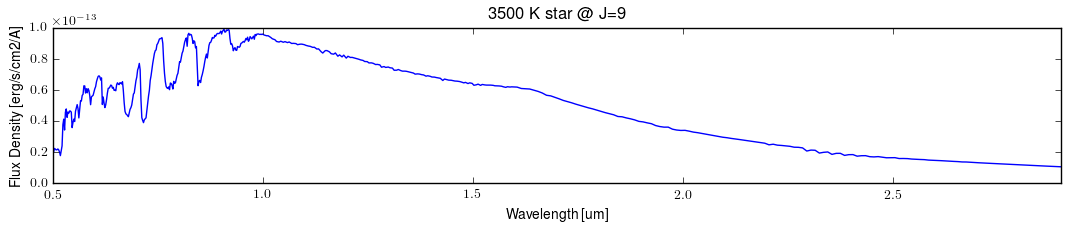

In [3]:
# Get the wavelength and flux of the star with units
star = np.genfromtxt(resource_filename('AWESim_SOSS','files/scaled_spectrum.txt'), unpack=True)
star1D = [star[0]*q.um, (star[1]*q.W/q.m**2/q.um).to(q.erg/q.s/q.cm**2/q.AA)]

# Plot it 
plt.figure(figsize=(13,2));
plt.plot(*star1D);
plt.xlim(0.5,2.9);
plt.title('3500 K star @ J=9');
plt.ylabel('Flux Density [erg/s/cm2/A]');
plt.xlabel('Wavelength [um]');

Now we can intialize the silumation.

In [1]:
# Initialize the simulation
ngrps, nints = 3, 100
TSO1 = awesim.TSO(ngrps, nints, star1D)

NameError: name 'awesim' is not defined

And then run the simulation (this takes about 2 minutes)...

In [ ]:
# Now run it
TSO1.run_simulation()

Calculating order 1 light curves...


In [ ]:
# Take a look
TSO1.plot_frame()

In [ ]:
TSO1.plot_slice(500)

## G 240-52 (M4)

This uses actual data, though there are gaps.

In [ ]:
# Get the raw data
wave_s_raw, flux_s_raw = np.genfromtxt(pkg_path+'/files/m4v_combined_template.txt', unpack=True)

# Scale by K magnitude
Kmag = 9.128 # From SIMBAD
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
M4 = [wave_s, flux_s]

# Plot it 
plt.figure(figsize=(13,2))
plt.plot(*M4)
plt.xlim(0.5,2.9)
plt.title('Stellar spectrum @ K={}'.format(Kmag))
plt.ylabel('Flux Density [erg/s/cm2/A]')
plt.xlabel('Wavelength [um]')

In [ ]:
# Initialize and run the simulation
ngrps, nints = 3, 100
TSO2 = awesim.TSO(ngrps, nints, M4)
TSO2.run_simulation()

In [ ]:
TSO2.plot_frame(order=1, scale='linear')
# This is way too thin and choppy. Try oversampling the psf so that
# the psf_position() draw is more varied.

In [ ]:
# Take a look!
TSO2.plot_frame(order=1, scale='linear')
TSO2.plot_frame(order=2, scale='linear')
TSO2.plot_frame(scale='linear')

In [ ]:
TSO2.plot_spectrum(order=1)

## WASP-107 TSO (without planet)

In [ ]:
# Stellar spectrum from model grid @ mu=1
teff, logg, feh = 4430, 4.51, 0.02
model_grid = core.ModelGrid(os.environ['MODELGRID_DIR'], Teff_rng=(4400,4500), logg_rng=(4.5,5), FeH_rng=(0,0.5), wave_rng=(0.5,2.8), resolution=700)
star = model_grid.get(teff, logg, feh)
wave_s_raw, flux_s_raw = star['wave'], star['flux'][-1]

In [ ]:
# Scale by K magnitude
Kmag = 8.637 # From SIMBAD
wave_s, flux_s, *_ = awesim.norm_to_mag([wave_s_raw*q.um,flux_s_raw*q.erg/q.s/q.cm**2/q.AA], Kmag, K)
WASP107 = [wave_s, flux_s]

# Plot it 
plt.figure(figsize=(13,2))
plt.plot(*WASP107)
plt.xlim(0.5,2.9)
plt.title('Stellar spectrum @ K={}'.format(Kmag))
plt.ylabel('Flux Density [erg/s/cm2/A]')
plt.xlabel('Wavelength [um]')

In [ ]:
# Initialize and run the simulation
ngrps, nints = 3, 100
TSO3 = awesim.TSO(ngrps, nints, WASP107, extend=100)
TSO3.run_simulation()

In [ ]:
TSO3.plot_frame()

## WASP 107 TSO (with planet)

We need five components to generate a transiting exoplanet:
- A flux calibrated stellar spectrum
- A time axis for each frame of the TSO
- A transmission spectrum of the planet
- A map of the limb darkening coefficients at each pixel
- The orbital parameters of the planet

We have the stellar spectrum from above so let's get the planetary transmission spectrum (generated with Exotransmit).

In [ ]:
# Get the forward model planet spectrum generated by Matt...
WASP107b = np.genfromtxt(pkg_path+'/files/WASP107b_pandexo_input_spectrum.dat', unpack=True)

# Plot it
plt.plot(*WASP107b)
plt.xlim(0.5,2.9)
plt.title('Planetary Transmission Spectrum @ mu=1')
plt.ylabel('Rp/R*')
plt.xlabel('Wavelength [um]')

Now we must calaulate a map of the limb darkening coefficients for the star through the GR700XD filter. This takes a few minutes so I precomputed and saved the values.

In [ ]:
# Specify the limb darkening profile
profile = 'quadratic'
filename = '{}_ldc_lookup_{}_{}_{}.save'.format(profile,teff,logg,feh)

# ============================================================================
# Generate a map of the LDCs at every pixel (Only do this once!)
# awesim.ldc_lookup(profile, star, model_grid, save=pkg_path+'/files/')
# awesim.ld_coefficient_map(pkg_path+'/files/'+filename)
# ============================================================================

# Get the LDC map from file
ld_coeffs = joblib.load(pkg_path+'/files/'+filename.replace('lookup','map'))

Now let's use Batman to set the orbital paramaters.

In [ ]:
# Set the wavelength independent orbital parameters
time_axis = np.linspace(-0.2,0.2, 100) #TSO3.time
params = batman.TransitParams()
params.t0 = time_axis[len(time_axis)//2]      # time of inferior conjunction
params.per = 5.7214742                        # orbital period
params.a = 0.0558*q.AU.to(ac.R_sun)*0.66      # semi-major axis (in units of stellar radii)
params.inc = 89.8                             # orbital inclination (in degrees)
params.ecc = 0.                               # eccentricity
params.w = 90.                                # longitude of periastron (in degrees)

# Test it
params.limb_dark = 'quadratic'
params.u = ld_coeffs[0][123]
params.rp = (0.94*ac.R_jup.to(ac.R_sun)*0.66).value

# Generate the light curve for this pixel
m = batman.TransitModel(params, time_axis)
lc = m.light_curve(params)
plt.plot(time_axis, lc)
plt.ylim(0.995,1.0005)

In [ ]:
lc = m.light_curve

Now we can run the simulator.

In [ ]:
# Create TSO object
ngrps, nints = 3, 100
TSO4 = awesim.TSO(ngrps, nints, WASP107, WASP107b, params, ld_coeffs)
TSO4.run_simulation(orders=[1,2])

In [ ]:
TSO4.plot_frame()

In [ ]:
TSO4.plot_lightcurve([15,300,500])